# Chapter 02 End to End Machine Learning Project

### Working With Real Data

When we are learning machine learning, it is best to experiment with real life data, not artifical datasets. Fourtunetly there are loads of datatsets we can acess in order to teach ourselfs how machine learning works.

Popular open data repositories
- UC Irvine Machine Learning Repository
- Kaggle datasets 
- Amazons AWS Datasets

Meta portals
- Data portals
- OpenDataMonitor 
- Quandl 

Other pages listing many popular datasets 
- Wikipedias list of machine learning datasets
- Quora.com
- The datasets subreddit

In this chapter we will be using California Housing Prices dataset from the StatLib repository. This is based on data from the 1990 California Census. The author has also removed some data columns and added a categorical attribute for teaching purposes.

# Look at the Big Picture

We will now be working as a machine learning engineer for the Machine Learning Houses Corporation! Our first task is to use the California census data to build a model of housing prices in the state. This data includes metrics such as the pupulation, median income, and median housing price for each district. 

Our model should learn from this data and be able to predict the median housing price in any district, given all the other metrics. 

Since we are a well organised data scientist we will use our data science checklist

### Download the Data

In a typical envrionment your data would be available in a relational database or another common data store, spread across multiple tabels and documents. To access this we would first need to get our credential and access authorisation, then we familairise ourselfs with the data schema. In this project things are much simpler, we just need to download a single compressed file, housing.tgz which contains a comma-seperated values (CSV) file called housing.csv with all the data inside of it. 

We cold use a web brower to download the file and run tar xzf housing.tgz to decompress it and extract the housing csv file, but it is better to create a small function that will do all of this for us! So instead of manually sorting through all of this python will sort it for us!

Having a function that downloads the data is really helpful if the data we are working with is changing regularly, or we can set up a scheduled job that will do this automatically at regular intervals. Automating the process of fetching data is also useful if you need to install a dataset on multiple machines! So we just call the function on each machine adn the data will be fetched for us. 

In [90]:
import os 
import tarfile
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
# setting the variables that we are using in the function
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# setting up the function with the parameters
def fetch_housing_data (housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    '''
    creates a directory and loads the data from the url into the housing path 
    
    input = housing_url, housing_path
    
    output = csv file in the desired location
    '''
#   making a directory
    os.makedirs(housing_path, exist_ok=True)
#   setting a path to get the tgz path 
    tgz_path = os.path.join(housing_path, "housing.tgz")
#   retrieving the url 
    urllib.request.urlretrieve(housing_url, tgz_path)
#   tarfile allows us to read in tar files
    housing_tgz = tarfile.open(tgz_path)
#   extract all of the members in the directory or path
    housing_tgz.extractall(path=housing_path)
#   closing the file
    housing_tgz.close()

Now lets load the data using pandas, once again we shoul write a small function that does this for us

In [3]:
# setting up the function with the parameter that it needs to function
def load_housing_data_to_df(housing_path=HOUSING_PATH):
    '''
    creates a dataframe of the csv data
    
    input = housing path, where to find the data
    
    output = pandas dataframe of the data at the end of the path
    '''
#   setting up the path to get the csv data
    csv_path = os.path.join(housing_path, "housing.csv")
#   passing the csv path as the argument for the read_csv method
    return pd.read_csv(csv_path)

In [4]:
fetch_housing_data()
housing_data = load_housing_data_to_df()

In [5]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Lets Explore The Data

The rows are each housing district, there are 10 attributes of the data (columns). The info() method is a quick way to a description of the data we are using, in particular the number of rows, each attributes type, and the number of nonnull values 

In [6]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We can see there are 20,640 instances in this dataset, this is fairly small for machine learning but its a great place to start. Also note that total_bedrooms only has 20,433 values inside of that column, this means that there are 207 districts that do not have this data and are missing that feature, we will need to take care of this at some point. We can also see that all of the data in numerical bar the ocean_proximity data, which is an object type, this means it can hold any kind of Python object, but since we loaded this object from a CSV we know that this must be a text value (a string?). Now reading the ocean_proximity we can see that is looks sort of catagorical, how can we find out what the catagories are??? 

We can use the value_counts() method (we were also shown this in the pandas tutorial we did) 

In [7]:
# we are stating which column of the df we want to do our count with and then calling the value_counts method
housing_data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

So we have less than one hour from the ocean, inland, near the ocean, near the bay and an island catagory. It will be interesting to see the definitions of each of those catagories. However, lets look at the other fields, to do this we use the describe() function shows a summary of the numerical attributes

In [8]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


This shows us the counts, the mean, the standard deviation which shows how spread out (deviated) the values are, the minimum value. The 25%, 50% and 75% rows show the corresponding percentiles (a percentile indicates the value below which a given percentage of observations fall. For example 25% of districts have a housing median age lower than 18, 50& of them have a median age of 37 and 75% of them have a median age below 37.7. These values are often called the 25th percentile, or first quartile, with the median being 50% and the 75% percentile or the 3rd quartile. 

Another quick way to get a feel for the data is to produce histograms of each numerical value. A histogram shows us the number of instances on the vertical axis that have a given value range (so how many values fall into this range of numbers) the range of numbers are on the horizontal axis. We can either plot this one attribute at a time or we can call the hist() method on the whole dataset (this is in the following code) and it will plot a histogram for each numerical attribute 

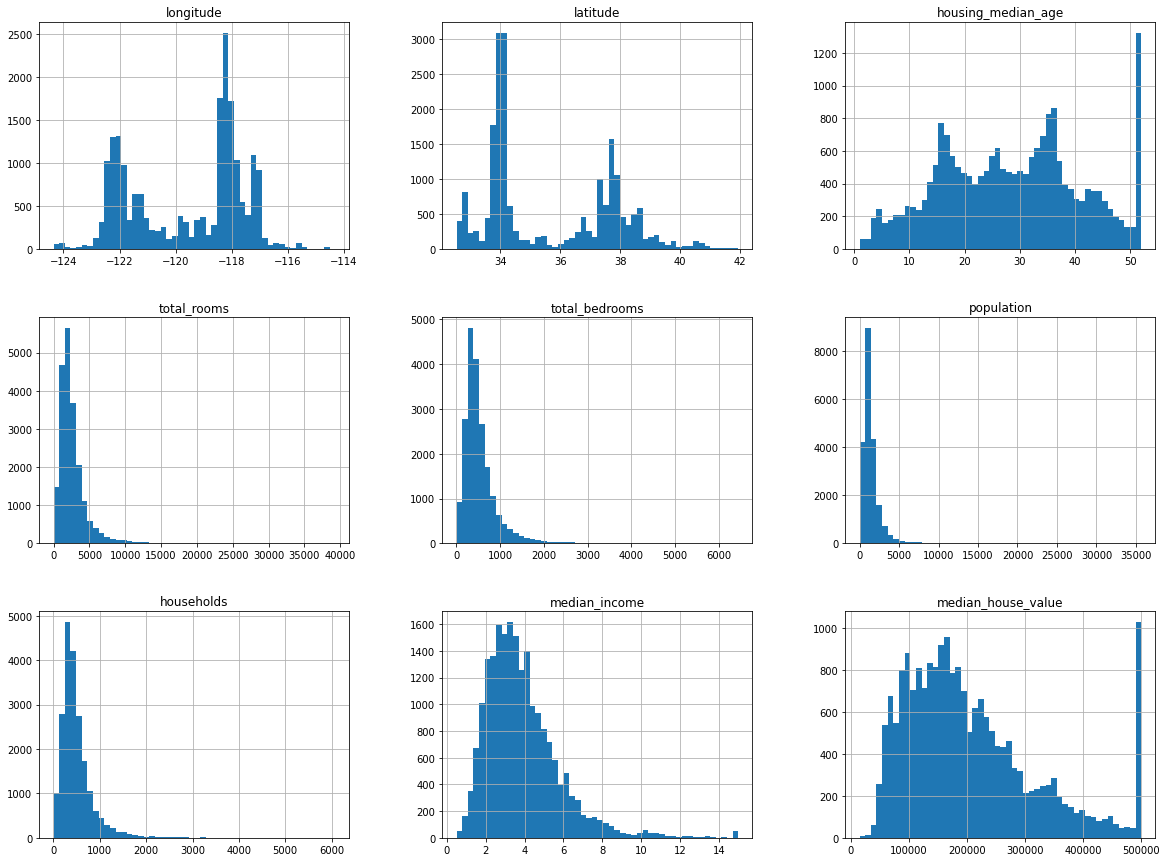

In [9]:
housing_data.hist(bins=50, figsize=(20,15))
plt.show()

What can we say about this data?? 

First the median income of each district seems like it is not calculated in USD, so we ask the team that came up with this data and we find that the data has actually been scaled and capped at 15 (15.0001) for the highest median incomes, and it has also been capped at 0.5 (0.4999) for the lowest median incomes. The numbers represent the 10s of thousands of dollars eg. 3 means around 30,000 dollars income, and 10 means 100,000 dollars of income etc. The book says that working with preprocessed attributes is common in machine learning and it is not necessarily a problem, but we should always try to figure out how the values we are analysing has been computed. 

Second, the housing median age and the housing median value seems to be capped too, THIS IS A PROBLEM as the housing median value is our target attribute (the value we are trying to predict) (we need to make extra sure that the target attribute is as we need it to be). This is important as the machine learning alogorithm could interpret this as houses don't go over 500,000. We check with the team that will be using our model and they say they need a precise number, not just above 500,000. So we have two options....

- Collect proper labels for those districts whole labels have been capped

- Remove those districts from the training set (and also from the test set) since our system should not be evaluated poorly if it predicts a value above 500,000 

Third we notice that all of these attributes (each graph) have been scaled very differently, this is okay as we will find out them it comes to feature scaling. 

Finally many of the histograms are tail-heavy, this means that they extend much farther to the right of the median than to the left of the median. This may make it a bit harder for some machine learning algorithms to detect patterns in the data. We will try to transform these attributes later on to try and give them a much more bell shaped curve.



WAIT !!!!!!!!

Before we read any further into our data it is CRUCIAL that we take some away for the test set and never look at it again until it comes to testing. 


### Create a Test Set

It might seem weird to set aside some of the data without exploring it in depth, this is true but our brain is very good at pattern recognision and if we look at the test set we could spot a pattern that influences the choice of model that we select later on down the line. When we estimate the generalisation error our estimation will be too optimistic this is called 'snooping bias' !!!!

Creating a test set is very simply in theory, we simply set aside 20% of our data at random, or less if it is a very large dataset. 

In [10]:
def split_into_train_test_sets(data, test_ratio):
    """
    splits the data into a train and test set according to the ratio
    
    input = dataframe, ratio of test to train
    
    return = dataframe of test and train data 
    """
#   shuffling the data using the random permutation of the length of the data
    shuffled_indicies = np.random.permutation(len(data))
#   setting the test length size (general, not setting it to 20% right away as this might change)
    test_set_size = int(len(data) * test_ratio)
#   slicing the array using the index operator, taking the values from 0 to the test set size
    test_indicies = shuffled_indicies[:test_set_size]
#   slicing the array from the test set size to the end using the slice operator 
    train_indicies = shuffled_indicies[test_set_size:]
    return data.iloc[train_indicies], data.iloc[test_indicies]

In [11]:
train_set, test_set = split_into_train_test_sets(data=housing_data, test_ratio=0.2)

print(len(train_set))
print(len(test_set))

16512
4128


This way works but it is not perfect, if we run this program again and again eventually we and the alogrithms we use will be able to see everything in the data. One solution is to save the test set then load it in everytime we run the program. Another option is to set the random number generators seed with np.random.seed(42) before calling the np.random.permutation(len(data)) so that it always saves the same indicies each time. 

However this will break the program if we load in the new data like we were talking about (automatically updating). A common way of maintaining a stable train/test set is to give each of the values a unique identifier and decide from there if it should be in the train or the test set. For example we can compute a hash for each instances identifier and put that instance in the test set. If the hash is lower or equal to 20% of the maximum hash value it will be placed into the test set. This means even if we refresh the dataset, the new test set will contain 20% of the new instances, but it will NOT contain any instances it might have seen before that was in the previous training set. 

In [12]:
def test_set_check(identifer, test_ratio):
    """
    returns a unique has for each idenitifier of the dataframe
    
    intput = itentifier and test ratio 
    
    output = hash value of the unique identifer
    """
    return crc32(np.int64(indentifer)) & 0xffffffff < test_ratio * 2**32

In [13]:
def split_train_test_by_id(data, test_ratio, id_column):
    """
    returns dataframes of the test and train sets
    
    input = data, test ratio and id coloumn
    
    output = dataframe of test and train data
    """
    ids = data['id_column']
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.iloc[~in_test_set], data.loc[in_test_set]

BUT our dataframe does not have a unique identifier column, the simplest solution is to use the row data index as the unique ID.

In [14]:
# creating a new dataframe with an unique index column
housing_with_id = housing_data.reset_index() # reset_index() adds the new index column as the row identifer 

In [15]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


However, scikit-learn allows us to use the train_test_split() function to do the same job that we have been doing before in the split_train_test() function we coded. There are a few more features in the train_test_split() function from scikit_learn such as the parameter 'random_state' that allows us to set a random generator seed. Secondly we can pass this function with multiple datasets, this is helpful when we have a seperate dataframe of labels where we can split the exact same instances and labels.

In [16]:
# setting the train/test split using the scikit learn function
train_set, test_set = train_test_split(housing_data, test_size=0.2, random_state=42)

print(len(train_set))
print(len(test_set))

16512
4128


We have only covered random methods of getting our train test split, in larger datasets this is okay, but in smaller datasets, we run a serious risk of introducing sampling bias into our test/train split. For example if the company asked 1000 people about their opinion they shouldn't just pick 1000 people at random, they should ensure that these 1000 people represent the whole population, such as sex (in the united states it is 51.3% female and 48.7% male) so this should be represented in the 1000 people in the questionare so it will be 513 females and 487 males. This process is termed 'stratified sampling'. The surveyed population is divided into homogenous subgroups called 'strata' and the right number of instances are sampled from each stratum to guarentee that the test set is representative of teh overall population. If the random methods we have used before are used, we could introduce a 12% sampling bias making a test set of 49% female or 54% female!!!! Either way we are introducing sampling bias.

Suppose we have spoken to the experts and they have told us that the median income of a district is a very important factor when predicting median house prices. So we want to make sure that the test set is representative of the various catagories on incomes in the whole dataset (we want to make sure each catagory % of income in represented fairly in the test set, say 100,000 makes up 10% of the data so we want it to make up 10% of the test set).

Lets look at the median income more closely. 

<AxesSubplot:>

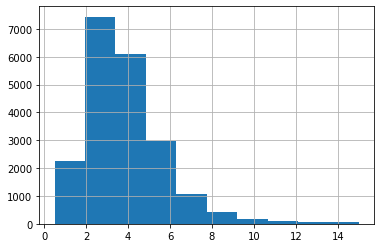

In [17]:
housing_with_id['median_income'].hist()

Here we can see that the majority of instances fall between 2 and 6 (20,000 to 60,000) with some instances coming far beyond 6. When we are constructing our stratum, it is really important that we have sufficient number of of instances in our dataset for each stratum or else our estimate of each stratum's importance will be bias. **This means we should not have too many strata and that each stratum is large enough!!!!!!** The following function uses the pd.cut() function to create an income cateogry attribute with five catagories from 1-5. 1 ranges from 0-15,000 catagory 2 ranges from 15,000 to 30,000 etc etc etc. 

We are creating a new column in the dataframe called income_catagories, where we use pd.cut() this allows us to sort data values into bins. It is also good at going from continuous data to catagorical data (which we are doing here). 

In [18]:
# creating the catagories for the median income data
housing_data['income_catagories'] = pd.cut(housing_data['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])

In [19]:
# proving that the income catagories column has been added to the dataframe
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_catagories
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


<AxesSubplot:>

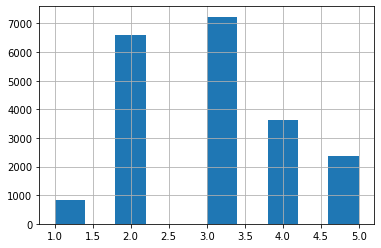

In [20]:
housing_data['income_catagories'].hist()

Now we are ready to do stratified sampling based on the income catagory. For this we use the scikit-learn StratifiedShuffleSplit class: 

In [21]:
# creating the stratified training testing split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_data, housing_data['income_catagories']):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

Lets see if this worked as expected, we can start looking at the income category proportions. 

To do this we divide the value counts of each catagory by the length of the stratifed test set.

In [22]:
strat_test_set['income_catagories'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_catagories, dtype: float64

With similar code we can measure the income catagory proportions in the full dataset, we do this by dividing the value counts for the income catagoires again, but this time we divide by the length of the whole dataset. 

As we can see the proportions are the same so our sampling method has worked, we have representative sampling in our test set!!!

In [23]:
housing_data['income_catagories'].value_counts()/len(housing_data)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_catagories, dtype: float64

Now we are going to remove this income_catagory attribute from the dataset so we are back to the original state of the data. We have explored generating a test set in depth here as it is often a part that is overlooked in machine learning, as well as this that, some of this stuff will be useful when we are cross validation.

Here we have made this stratified column so we can generate the stratified training and test set, but we now want to remove the column from the df so it represents the original data. 

In [24]:
# removing the income catagories column to set the data back to its orignal format
for set_ in (strat_test_set, strat_train_set):
    set_.drop('income_catagories', axis=1, inplace=True)

In [25]:
# proving that we have removed the column from the dfs, remember not to look at the test set data
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


In [26]:
# not looking at the data in the test df but I am checking the columns
strat_test_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [27]:
# removing the income catagories from the housing dataframe
housing_data.drop('income_catagories', axis=1, inplace=True)

In [28]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Discover and Visualise the Data to Gain Insights

So far we have only really glaced at the data to check our manipulations are correct and are working. Now are goal is to get into the nitty gritty of the data to gain insights into what we are doing. 

First we need to make sure we have put aside the test set and we are only exploring the training set. If the training set is really large it could be worth taking a sample of the training set in order to make the manipulations fast and easy. In our case, the training set is quite small so we can use it all !!!! 

Lets make a copy of the training set so we can play with it freely without fear of breaking or altering it!


In [29]:
# creating a copy of the training set dataframe
housing_df = strat_train_set.copy()

housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


### Visualising Geographic Data

Since we are working with geographical data, it is ideal to create a scatterplot of the longitude and latitude to give us an idea of the districts locations. 

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

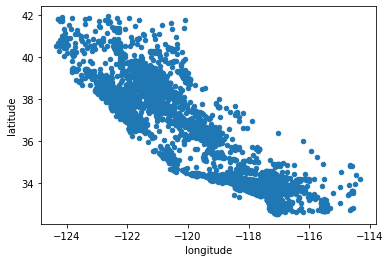

In [30]:
housing_df.plot(kind='scatter', x='longitude', y='latitude')

This looks like California !!! but it is really hard to get any significant information from this, if we set the alpha value to 0.1 it will be much easier to visulise the data where there is a high density of districts.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

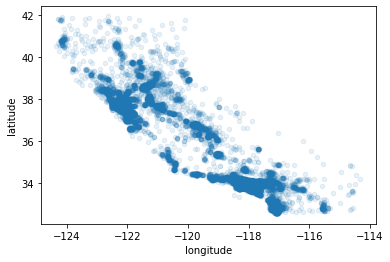

In [31]:
housing_df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

Now we can see the much denser areas in CA we can see there is a highly dense area around the Bay Area, Los Angeles and San Diego. There is also a long line of dense districts further inland, this is the Central Valley. Our brains are really good at spotting patterns so we might have to play around with the plot a little bit in order to understand it some more. 

Now lets look at the housing prices, the radius of each circle represents the district pupulations and the colour represents the price, the author uses the colour map 'jet' but I really like the look of magma, so I will use that instead. 

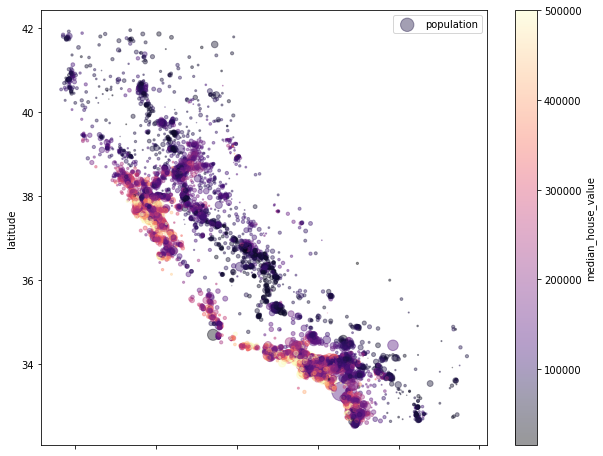

In [32]:
housing_df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
               s=housing_df['population']/100, label='population', figsize=(10,8), 
               c='median_house_value', cmap=plt.get_cmap("magma"), colorbar=True)
plt.legend()

##### No x label for some reason???? Need to fix it

This figure shows us that the location of the district does have an effect on price, we can see that locations near the beach have a higher price than those further inland as well as it being relational to population density (the more dense the more expenseive) 


We should use a clustering algorithm to detect the main clusters and for adding a new feature that measures the proximity to the cluster center. Also adding ocean proximity attribute might be helpful but up in the northern parts houses that are close to the sea are not that expensive so it might not be as simple as that!


### Looking for Correlations

since our dataset is not too large it is easy to computre the standard correlation coefficient (also called the Pearson's R) between every attribute in the df using the corr() method.

In [33]:
# creating a matrix of the correlation coefficient
correlation_matrix = housing_df.corr()

# showing the whole matrix
correlation_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


Now lets look specifically at the median house value and how that correlates to all of the other attributes. 

In [34]:
# accessing a certain part of the correlation matrix
correlation_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

The correlation coefficient ranges from -1 to 1, the closer it is to 1 the stronger the postive correlation. For example the median income has a strong positive correlation to the median house value, if the median house value increases the median income will increase too !!! If the value is close to -1 there is a strong negative correlation, we can see a small negative correlation between latitude and the median house value (house price tends to decrease the further up north we go (as latitude increases, value decreases)). Finally coefficents close to 0 mean that there is NOOOOOOO linear correlation between the two attributes!!!!!!!

The correlation coefficient only measures linear correlations (if x goes up, y generally goes up or down depending on the positive or negative correlation), also note this has nothing to do with the slope of the data. If data  has a non linear relationship, the correlation coefficient only measures linear correlations so using this is not a way we can detect non linear relationships!!!

Another way to check the correlation between attributes is to use the pandas scatter_matrix() function, which plots every numerical attribute against every other numerical attribute. However since there are now 11 numerical attriubutes, there will be 121 plots, which will not fit on the page so lets just focus on the attributes that seem most correlated to the median_house_value

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

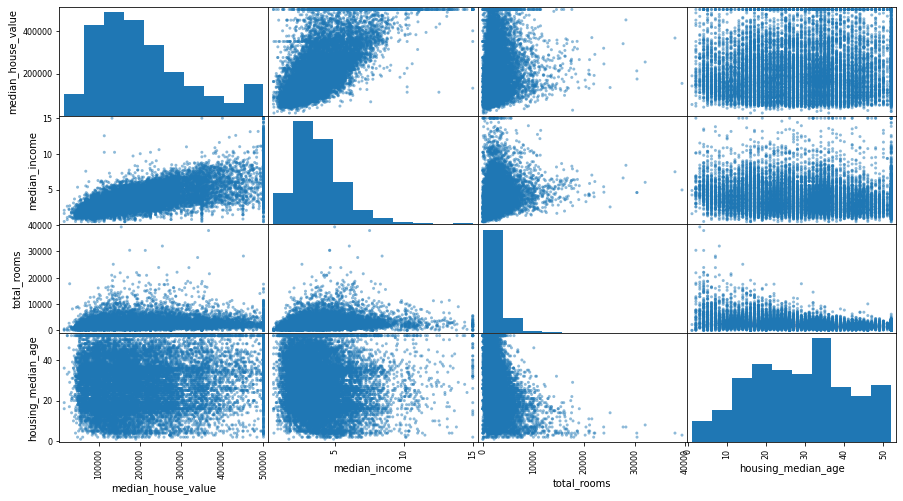

In [35]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing_df[attributes], figsize=(15,8))

The diagonal values top left to bottom right would be straight lines if they were plotted against eachother so pandas has plotted each attribute as a histogram. 

The most promising attribute to predict the median house value is the median income, so lets talk about their correlation scatterplot.

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

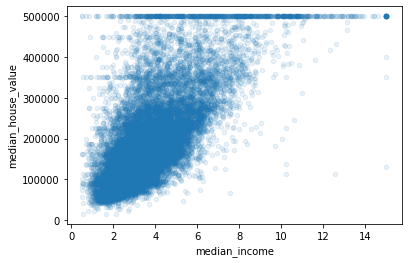

In [36]:
housing_df.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

This plot reveals a few things, first that the correlation is indeed very strong, we can clearly see an upward trend and the points are not too dispersed. The second the price cap at 500,000 is clearly noticable. We can also see faint lines horizontal lines around 350,000 and 450,000. There also seem to be some faint lines at 250,000 and 125,000 We may want to try removing the corresponding districts to prevent our algorithms from learning to reproduce these data quirks.

### Experimenting with Attributes Combinations

The previous section has given us an idea of what it is like to visulise the data a bit more indepth. We have found there is a large correlation between the median value of the house and the median income of the occupants, we have found some other smaller correlations with the data as well. There is some attributes that we rather tail heavy so we might want to transfrom these by computing their logorithm. We have also found some quirky data that we might want to clean up before feeding it into the machine learning algorithm.

One last thing we should talk about before we start feeding our data into the machine learning algorithm is why we should try out differnt combinations of attributes. For example the total number of bedrooms inside of a district is not really important if we don't know how many households are in that district. Furthermore, the total number of bedrooms might not be as helpful as the total number of rooms as a whole, the total number of people in the household also seems like an interesting attribute to have, as the amount of people that live in a house might have an effect on the price of the house.

So lets create the attributes

In [37]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


In [38]:
# computing the rooms per household attribute
housing_df['rooms_per_household'] = housing_df['total_rooms'] / housing_df['households']
# computing the bedrooms per room in each household
housing_df['bedrooms_per_room'] = housing_df['total_bedrooms'] / housing_df['total_rooms']
# computing the population per household 
housing_df['persons_per_household'] = housing_df['population'] / housing_df['households']

In [39]:
# lets look at the correlation matrix for the median household value again to see if this attributes correlate at all
corr_matrix = housing_df.corr() # this is the the whole matrix
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value       1.000000
median_income            0.687151
rooms_per_household      0.146255
total_rooms              0.135140
housing_median_age       0.114146
households               0.064590
total_bedrooms           0.047781
persons_per_household   -0.021991
population              -0.026882
longitude               -0.047466
latitude                -0.142673
bedrooms_per_room       -0.259952
Name: median_house_value, dtype: float64

We can see that rooms per household actaully has a rather strong positive correlation with the median house value, and that the attribute rooms per household has more of a correlation then the original total rooms. We can also see that the persons per household and the bedrooms per household have negative correlations with the data, so as the median house value goes up the two attributes seem to come down (this is weird, why do we think this is happening). But it is imporant to know that the bedrooms per room attribute has much more of a correlation with the median house value that the total rooms which is great, because we made this attribute ourselves. 

This round of data exploration we have done is not the most indepth but it is enough for us to get an idea of what is a reasonbly good prototype. But this process is an ITERATIVE process.... once we have our prototype up and running we should come back and do a much more indepth dive into the data to wrangle some more information out of it. 

# Prepare the Data for Machine Learning Algorithms

Now is the time to start preparing our data to feed into the machine learning algorithm, instead of doing this by hand WE SHOULD USE FUNCTIONS that will do this for us, this allows us to repeat our transformataions multiple times without a lot of work, it allows us to build up a library of tranfromation functions that we can use in future projects and we can use these functions in our live system too to transform new data before feeding it into the machine learning algorithm. This will also make it easier to try various transformations and see which combination of transformations works best. 

--- Note --- 

Data transformation is defined as the process of changing the structure, format or values of data


But first lets revert back to the orignial training set by copying strat_train_set. Lets also seperate the predictors and the labels since we do not necessarily want to apply the same transfromatiosn to the predictors as we do the target values. 

In [40]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


In [41]:
# lets seperate the predictors from the predictors (median house value) using the pandas drop() method

# assinging the variable equal the dataframe without the labels in
housing_wo_lables = strat_train_set.drop('median_house_value', axis=1)
# making a new dataframe with the median house values inside
housing_labels = strat_train_set['median_house_value'].copy()

In [42]:
# proving that there are no labels
housing_wo_lables.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


In [43]:
# proving there is the other df with just the labels, remeber this is still just the training set 
housing_labels.head()

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
Name: median_house_value, dtype: float64

### Data Cleaning

Most machine learning algorithms cannot function with missing data values, we saw before that some of the values in total bedrooms had some missing values, we have to deal with these and there are 3 ways to do it. 

- Get rid of the districts that correspond to the missing data
- Get rid of the attribute all together
- Set the values to some value (zero, the mean, the medain etc) 

We can do this using the dropna(), drop() or fillna() methods. 

Option 1
housing.dropna(subset=['total_bedrooms'])

Option 2
housing.drop('total_bedrooms', axis=1) 

Option 3 
housing['total_bedrooms'].fillna(median, inplace=True)


Now if we choose option number 3 we need to compute the median value on the TRAINING SET and use that median value to fill in the empty values in the bedrooms in the training set. We need to save that value, so we can use it later when we are filling in missing values in the new data. It is also important to remeber that we can only compute the medians of integer values so we need to remove the ocean_proximity column while we do this. 

scikit-learn has a handy class that allows us to take care of these missing values called 'SimpleImputer'. We will now learn how to use this SimpleImputer. First we need to make and instance of the SimpleImputer class and specify that we want to replace each atttributes missing values with the medain of that attribute. 

In [44]:
# creating an instance of the class SimpleImputer and telling it we want to use the median
imputer = SimpleImputer(strategy='median')

# remeber we can only compute this value on numerical attributes so we need to remove the ocean proximity
housing_numbers = housing_wo_lables.drop('ocean_proximity', axis=1)

Now we have dropped in ocean proximity column we can now fit the imputer instance to the training data using the fit() method. We need to fit this to the training set at the imputer fills in missing values of the data and to avoid 'data leakage' during cross validation it computes the given statistic on the train data during the fit stage and stores it for use on the test dataset during the transform stage

In [45]:
# fitting the imputer instance to the training set without the labels 
imputer.fit(housing_numbers)

SimpleImputer(strategy='median')

This imputer has simply calculated the median of each attribute stored in its statistics_ instance variable. At the moment on the bedroom attribute is missing values, but we don't know what data will be missing in the future so it is worth calculating the median by applying to imputer to all of them for use later! 

In [46]:
# checking the statistics_ instance 
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [47]:
imputer.strategy

'median'

In [48]:
# checking the median valuessdsxss
housing_numbers.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Now we can use this 'trained' imputer to transform the training set by replacing the missing values with the medians it has learned.

In [49]:
# setting the variable x to equal the transformed housing numbers data
X = imputer.transform(housing_numbers)

Doing this results in a plain NumPy array containing all of the transformed features, if we want to put this back into a dataframe we do this 

In [50]:
# setting the variable housing transformed to be a datframe, setting the data, then the columns and then the index 
housing_transformed = pd.DataFrame(X, columns=housing_numbers.columns, index=housing_numbers.index)

In [51]:
housing_transformed.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


### Scikit-Learn Design 

Scikitpleanrs API is well desinged, here are the main prinicples !!!

**Consistancy** 

All objects share a consistent and simple interface
    
    **Estimators** 
    
     Any object that can estimate some parameters based on a dataset is called an 'estimator' (the imputer we have used above is an estimator. The estimation itself is performed by the fit() method when it is called. The fit method only takes one parameter and that is the dataset. If it is a supervised learning algorithm the fit method will take two parameters, the first being the dataset and the second being the the labels of the first dataset. Any other parameter in the method that is needed for the estimation process is a hyperparameter (such as the imputers strategy that we set set above) and this must be set as an instance variable. 
     
    **Transformers**
     
     Some estimators (like the imputer we used before) can also transform the a dataset, these are called 'transformers'. Once again the API is simple, the transformation action is performed by the transform() method with the dataset that we are looking to transform as a parameter for the method. This method returns the transformed dataset. This transformation relies on the learned parameters (such as the imputer). All transformers also have the convenience method called fit_transform(), this is the same as calling, fit() then transform(), but sometimes fit_transform() is optimised to run faster. 
     
     **Predictors**
     
     Finally, some estimators, given a dataset are capable of making predictions. These estimators are called 'predictors'. For example the linear regression model that was used in the previous chapter was a predictor. Given a countries GDP per captia, 'predict' what their happiness is. A predictor has the method predict(), that takes the dataset of new instances and returns a dataset of corresponding predictions. It also has a score() method, this score() method measures the quality of the predictions of a given test set (and the corresponding labels if used in a supervised learning algorithm). 
     
**Inspection** 
     
All estimators hyperparameters are accessile directly via public instance variables (an example of this would be the strategy hyperparameter of the imputer instance) we access this using the dot notation (imputer.strategy), and all of the estimators learned parameters are accessible via public instance variables WITH AN UNDERSCORE SUFFIX (  imputer.statistics_ ) 
     
**Nonproliferation of Classes** 
     
Datasets are represented as NumPy arrays or SciPy spase matrices, instead of homemade classes. Hyperparameters are just regualr Python strings or numbers.
     
**Composition** 
     
Existing building blocks are reused as much as possible. For example it is easy to create a 'Pipeline' estimator from an arbitary sequences of transformers followed by a final estimator as we will see soon!!!!!

**Sensible Defaults** 

Scikit-learn provides reasonable default values for most of the parameters, making it easy and quick to create a baseline working system. 
     


### Handling Text and Catagorical Attributes

So far we have only covered numerical attributes, but now we need to look at text attributes, such as this ocean_proximity attribute of the california house data from before. Lets look at the first 10 values of this column

In [52]:
# creating a new variable to work with 
housing_catagory = housing_wo_lables[["ocean_proximity"]]

In [53]:
housing_catagory.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [54]:
# looking at the value counts
housing_catagory['ocean_proximity'].value_counts()

<1H OCEAN     7277
INLAND        5262
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

As we can see, this is not arbitrary text, there are a limited nuber of possible values, each of which represents a catagory. This means that the attribute is called a 'catagorical attribute' (it is an attribute that is split into catagories), so we can convert these catagoires into numbers. To do this we use the OrdinalEncoder class.

In [55]:
# creating an instance of the ordinal encoder class
ordinal_encoder = OrdinalEncoder()

# encoding the ocean_proximity catagories, note we use the fit_transform method with the data as the parameter
encoded_housing_catgories = ordinal_encoder.fit_transform(housing_catagory)

# proving it has worked using a sliced list
encoded_housing_catgories[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

Here we can see the first 10 values and what numerical value they have been given. We can also get a list of categories using the catagoires_ instance variable. In this instance variable, there is a list that contains a 1D array of the catagories inside the catagory attribute. Note the list goes from 0-4 for our list or 0-infinity. 

In [56]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this is that the machine learning algorithm WILL assume that two nearby values are more similar than two distant values. This may be fine in catagories that are split bad, ok, good, excellent. But in ocean_proximity that is not the case. For example, the catagories in our problem 0 and 4 are much more similar and 0 and 1. To fix this issue we need to create one binary attribute per catagory: one attribute equal to 1 when the category is "<1H OCEAN" and 0 otherwise. This allows us to convert a name or label or in thise case the attribute catagoires into vectors that the machine learning algorithm will understand. This technique is called "One Hot Encoding" becuase one of the attributes catagories will equal to 1 (hot) while the rest will equal 0 (cold) 

Scikit-learn provides a OneHotEncoder class to covert the catagorical values into one-hot vectors!

In [57]:
# Creating an instance of the class
catagory_encoder = OneHotEncoder()

# using the encoder
housing_catagory_1hot = catagory_encoder.fit_transform(housing_catagory)

# proving that this has worked, we should return a sparse matrix 
housing_catagory_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Notice that we get a SciPy 'sparse matrix' instead of a NumPy array. This is very useful when we have catagorical attributes with thousands of catagories. If we do one hot encoding on all of the catagories we will get a matrix with thousands of columns, and the matrix if full of 0s except for a single 1 per row. Using up tons of memory to store the 0s woulf be wasteful, so a sparse matrix will only store the position of the nonzero elements (the ones). We can use it like a normal 2D array, but if we really want to we can covert it into a dense NumPy array using the 'toarray()' method. Like below ! 

In [58]:
# here we can see the 1 hot encoder matrix
housing_catagory_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Note that once again we can get the list of catagories using the encoders categories_ instance variable 

In [59]:
catagory_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

If a categorical attribute has a large number of possible categories (such as a country code, profession or species of animal) then one-hot encoding wil result in a large number of input features. This will slow down the process and may even degrade performance. If this is the case, we need to convert the catagoires into a numerical input, such as turning ocean_proximity into just distance away from the ocean with a numerical value, this means we can do the same statistical analysis as we have done on all of the numerical data before. Similarly, a countries code could be replaced with the population or the GDP per capita. Alternativly we could replace each category with a learnable, low dimensional vector called an 'embedding'. Each catagorys representation would be learned during training. This is an example of 'representation learning' we will talk more about this further into the book. 

### Custom Transformers

Although scikt-learn provides many useful transformers, we will need to be able to create our own for tasks such as custom cleanup operations, or combining specific attributes. We will want this transformer to work seamlessly with Scikit-learn functionalities (such as their pipelines), and since scikit-learn relies on 'duck typing' and not inheritance, all you need to do is create a class and implement three methods, fit() (this must return self), transform() and fit_transform(). 

We can get the last one for free by simply adding "TransformerMixin" as a base class. If we add another base class called "BaseEstimator" (we must avoid *args and *kwargs (uses two *'s on the kargs but this just makes it bold so can't do this) using the BaseEstimator class will give us two extra methods 'get_params()' and 'set_params()' these are both really useful when we are tuning hyperparameters. 

--- Note --- 

- Base class = parent class, so we create a main (base/parent) class to which we create child classes.
- args and kwargs = args allows us to pass multiple positional arguments into the function, kwargs does the same thing but with keyword arguements, these basically allow us to pass multiple things into the function instead of just being able to pass one for each argument or keyword argument

For example, below is a small transformer class that adds the combined attributes that we walked through ealier. 

In [65]:
housing_wo_lables.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


In [85]:
# Columns in the dataframe I believe, the book doen't say, I believe we set this each time we need to use this function
# a new time. The syntax will read, dataframe[:, column_ix] where : = all of the values in that column
rooms_ix = 3
bedrooms_ix = 4
population_ix = 5
households_ix = 6


# setting up the base class with 
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
#   creating the init method
    def __init__(self, add_bedrooms_per_room:bool = True): #no args or kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
#   creating the fit() method
    def fit(self, X, y=None):
        return self

#   creating the transform method, it takes the parameter X (this is the dataset we pass in I believe)
    def transform(self, X):
#       how we calculate the rooms per household
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
#       how we calculate the population per household
        population_per_household = X[:, population_ix] / X[:, households_ix]
#       if statement, comptues if we want bedrooms per room or not
        if self.add_bedrooms_per_room:
#           computing the bedrooms per room
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
#           np.c_ concats each series 
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
       
    
# creating an instance of the custom class    
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
# when calling the function we use .values, this creates an array so we are not passing in a dataframe
housing_extra_attributes = attr_adder.transform(X=housing_wo_lables.values)
# checking to two extra attributes are at the end
housing_extra_attributes

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], dtype=object)

In this example the transformer has one hyperparameter, add_bedroons_per_room, set to True by default (it is often helpful to provide sensible defaults). Note that when we call this we set the hyperparameter to False! This hyperparameter will allow you to easily find out whether adding this attribute helps the machine learning algorithms or not. More generally you can add a hyperparameter to gate any data preparations steps. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination of attributes (this will also save us a lot of time compared to comparing these manually).

### Feature Scaling

One of the most important transformations we need to apply to our data is called 'feature scaling'. Bar a few examples, machine learning algorithms do not like to work with numerical inputs that have very different scales. This is the case for the housing data we are working with now, such as the number of rooms ranging from 6 to 39,320 (wow ahahah) compared to the median income that only ranges from 0 to 15 (NOTE - scaling target values is generally not required) 

There are two types of scaling, 'min-max' scaling and 'standardisation' scaling.

Min-max scaling is also called normalisation, is where the values are shifted so they fit into the gap between 0 and 1. We do this computation by subtracting the minimum value and dividing by the maximum value minus the min value. 

Scikit-learn has a transformer that does this for us called MinMaxScaler. It takes the input 'feature_range' hyperparameter that lets us change the range if for some reason we dont't want 0-1

Standardisation is a different form of feature scaling, first it subtracts the mean value (standardised values always have a mean of 0), then it divides by the standard deviation so that the resulting distribution of values has unit variance (as the standard deviation and well as the variance will head towards 1, as the sample size heads towards infinity). Unlike min-max scaling, standardisation does not bind values to a specific range, which migth cause problems for some alogrithms such as neural networks that work in binary from what I know. However the bonus of standardisation is that it is not as vunerable to outliers. For example lets say we have a mistake in out data and supposed one districts median income equals 100 by mistake. Min-max scaling would crush the values from 0 to 15 down to 0.015, whereas standardisation would not be much affected! 

Scikit-learn has a transformer for StandardScaler for standardisation. 

As with all transformation it is important to fit these scalars to the training data only. NOT THE FULL DATASET (including the test set). Only then do we use them on the training set then the test set, but we must FIT the SCALARS to the TRAINING SET ONLY.

### Transformation Pipelines

As we have seen through our walkthough of transformations, we can see there are many steps needed in the right order. Scikit-learn provides a Pipeline class to be used in such situations, where sequences of transformations matter. the Pipeline constructor takes a list of name/estimator pairs that define a sequence of steps, THEY MUST HAVE A FIT_TRANSFORM() METHOD, but they can be named anything we like!!! These names will come in handy when it comes to hyperparameter tuning. Here is a small pipeline for the numerical attributes we have walked through. 

In [89]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_numbers_transformed = numerical_pipeline.fit_transform(housing_numbers)
housing_numbers_transformed

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

So far we have handled the numerical and catagorical data seperatly. It would be more convenient to handle them both together while applying the appropriate transformations to each of them. To do this we can use scikit-learns ColumnTransformer and it works great with pandas dataframes. Lets use the ColumnTransformer to work with the whole dataset in the housing data. 

In [104]:
number_attributes = list(housing_numbers.columns) #list of the numerical columns
catagorical_attributes = ['ocean_proximity'] #becuase we don't want the data, we are simply it where to go

full_pipeline = ColumnTransformer([
    ("num", numerical_pipeline, number_attributes),
    ("cat", OneHotEncoder(), catagorical_attributes)
])

housing_prepared = full_pipeline.fit_transform(housing_wo_lables)

First we import the ColumnTransformer class, next we generate a list of the columns in the dataframe that are numerical data, we then state the name of the column that is the catagorical data. 

Then we construct the ColumnTransformer, this construcutor requires a list of tuples, where each tuple contains a name, a transformer and a list of names or inidices of columns that we are tansforming. In this example we specify which columns are numerical and which are catagorical and use those variable in the tuple. We also state which transformer needs to be used, such as the numerical_pipeline we constructed earlier for the numerical data and the one-hot encoder that is native to scikit learn. Finally we apply this ColumnTransformer to the housing data it applies each of those transformers to the appropraite columns and concatenates the outputs along the second axis (note that the transfromers must return the same number of rows) 

Note that the one-hot encoder will return a sparse matrix of values where the numerical_pipeline returns a dense matrix. When there is a mix like above, the ColumnTransformer will estimate the density of the final matrix that is produced. If it is passed a certain threshold it returns a dense matrix, if it is below a certain threshold it will return a sparse matrix (default value of 'sparse_threshold =0.3'). In this example it returns a dense matrix!

If we don't want to use a transformer and we just want to drop the data we can use the string "drop" or "pass through" if we want the columns to be left untouched. We have ran ours through all of the columns just in case some new data that is added is a not what we want it to be!

**We are done, we have taken our data, examanined it, found out what we need to do and applied to appropriate transformers to each column.**